# Linear network training and replay

In [1]:
from yawning_titan.networks.node import Node
from yawning_titan.networks.network import Network

import time
from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.callbacks import EvalCallback
from stable_baselines3.common.monitor import Monitor
from stable_baselines3 import A2C, DQN, PPO
from stable_baselines3.ppo import MlpPolicy as PPOMlp

from yawning_titan.envs.generic.core.blue_interface import BlueInterface
from yawning_titan.envs.generic.core.red_interface import RedInterface
from yawning_titan.envs.generic.generic_env import GenericNetworkEnv
from yawning_titan.envs.generic.core.action_loops import ActionLoop
from yawning_titan.envs.generic.core.network_interface import NetworkInterface
from yawning_titan.networks.network_db import default_18_node_network
import yawning_titan.game_modes
from yawning_titan.envs.generic.core.action_loops import ActionLoop

## Using DB to retrieve game modes
from yawning_titan.game_modes.game_mode_db import GameModeDB, GameModeSchema
from yawning_titan.db.doc_metadata import DocMetadataSchema
db = GameModeDB()

C:\Users\olive\yawning_titan\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Network Setup

Network of 5 nodes, connected in a line. Node 1 is the entry node and node 5 is the high value target. All nodes begin with an initial vulnerability of 0.3.

In [2]:
# Instantiate the Network
network = Network()

# Instantiate the Node's and add them to the Network
 
pc_1 = Node("PC 1")
network.add_node(pc_1)
pc_1.x_pos = -1.00
pc_1.y_pos = 0.01
pc_1.entry_node = True
pc_1.vulnerability = 0.8

pc_2 = Node("PC 2")
network.add_node(pc_2)
pc_2.x_pos = -0.50
pc_2.y_pos = 0.01
pc_2.vulnerability = 0.8

pc_3 = Node("PC 3")
network.add_node(pc_3)
pc_3.x_pos = 0.00
pc_3.y_pos = 0.01
pc_3.vulnerability = 0.8

pc_4 = Node("PC 4")
network.add_node(pc_4)
pc_4.x_pos = 0.50
pc_4.y_pos = 0.01
pc_4.vulnerability = 0.8

pc_5 = Node("PC 5")
network.add_node(pc_5)
pc_5.x_pos = 1.00
pc_5.y_pos = 0.01
pc_5.high_value_node = True
pc_5.vulnerability = 0.8


# Add the edges between Node's
network.add_edge(pc_1, pc_2)
network.add_edge(pc_2, pc_3)
network.add_edge(pc_3, pc_4)
network.add_edge(pc_4, pc_5)



# Reset the entry nodes, high value nodes, and vulnerability scores by calling .setup()
# network.reset()

# View the Networks Node Details
network.show(verbose=True)

UUID                                  Name    High Value Node    Entry Node      Vulnerability  Position (x,y)
------------------------------------  ------  -----------------  ------------  ---------------  ----------------
b75a9424-5c21-4379-abba-6296ad6e49b6  PC 1    False              True                      0.8  -1.00, 0.01
3afd6bca-8b71-451f-ac05-23c62869f31d  PC 2    False              False                     0.8  -0.50, 0.01
f2882641-56a0-43c2-b28d-b0deed647b19  PC 3    False              False                     0.8  0.00, 0.01
113e6418-c7d4-4f9d-830c-352cb2216bc2  PC 4    False              False                     0.8  0.50, 0.01
f08e2045-55b8-4c23-8d11-fd85d107f15f  PC 5    True               False                     0.8  1.00, 0.01


## Creating environments and training

In [3]:
# load notebook extension
%reload_ext tensorboard

In [4]:
db.show(True)

name               author              locked    uuid
-----------------  ------------------  --------  ------------------------------------
DCBO Agent Config  dstl/YAWNING-TITAN  True      bac2cb9d-b24b-426c-88a5-5edd0c2de413
Default Game Mode  dstl/YAWNING-TITAN  True      900a704f-6271-4994-ade7-40b74d3199b1
Low skill red      dstl/YAWNING-TITAN  True      3ccd9988-8781-4c3e-9c75-44cc987ae6af
simple_mode        Hannah Harrison     False     919da33c-7bc9-4d29-99eb-097a7e9bb016
no_zero_day        Hannah Harrison     False     fe76bb6c-4806-41af-aaf3-ac78d2942021


### Simple mode:
simple_mode 

#### Red: 

Can attack from any node it controls 

Only basic attack and zero day enabled. 

Starts with one zero day attack and gains another every 5 timesteps 

No natural spreading 

Target mechanism: (prioritise vulnerable nodes – sorts nodes it can attack and selects most vulnerable) changed to random 

#### Blue: 

Action set: reduce vulnerability, restore node (considering taking away restore node as kept winning by immediately restoring first node red attacks) 

100% chance of immediately discovering intrusions 

#### Game rules: 

Max steps: 30, no grace period 

Blue loss if high value node lost

#### Observation space 

Compromised status, vulnerability scores and node connections. I removed special nodes as this is kind of inferred by the rewards and adds a lot of dimensions.

#### Rewards 

-100 for loss, 100 for reaching end.  

Negative reward reduced for closer fails – if closer to end of timesteps 


In [5]:
simple_mode = db.get("919da33c-7bc9-4d29-99eb-097a7e9bb016")

In [6]:
## Build network interface
s_network_interface = NetworkInterface(game_mode=simple_mode, network=network)

## Name agents
red = RedInterface(s_network_interface)
blue = BlueInterface(s_network_interface)

## Create environment
s_env = GenericNetworkEnv(red, blue, s_network_interface)

## Check compliant with OpenAI gym
check_env(s_env, warn=True)
_ = s_env.reset()

In [7]:
## Initialise environment callback
eval_callback = EvalCallback(Monitor(s_env), eval_freq=1000, deterministic=False, render=False)

## Create agent
s_agent = PPO(PPOMlp, s_env, verbose=1, tensorboard_log="./logs/ppo_linear_tensorboard2/")

## Train agent for 200,000 timesteps
s_agent.learn(total_timesteps=200000, n_eval_episodes=1, callback=eval_callback)
%tensorboard --logdir ./logs/ppo_linear_tensorboard2/

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Logging to ./logs/ppo_linear_tensorboard1/PPO_14
Eval num_timesteps=1000, episode_reward=-54.84 +/- 18.95
Episode length: 18.20 +/- 6.49
---------------------------------
| eval/              |          |
|    mean_ep_length  | 18.2     |
|    mean_reward     | -54.8    |
| time/              |          |
|    total_timesteps | 1000     |
---------------------------------
New best mean reward!
Eval num_timesteps=2000, episode_reward=-75.74 +/- 12.81
Episode length: 13.40 +/- 4.03
---------------------------------
| eval/              |          |
|    mean_ep_length  | 13.4     |
|    mean_reward     | -75.7    |
| time/              |          |
|    total_timesteps | 2000     |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 16       |
|    ep_rew_mean     | -57.7    |
| time/              |          |
|    fps     

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 19.2     |
|    ep_rew_mean     | -39      |
| time/              |          |
|    fps             | 544      |
|    iterations      | 6        |
|    time_elapsed    | 22       |
|    total_timesteps | 12288    |
---------------------------------
Eval num_timesteps=13000, episode_reward=-62.35 +/- 13.69
Episode length: 16.80 +/- 4.79
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 16.8        |
|    mean_reward          | -62.4       |
| time/                   |             |
|    total_timesteps      | 13000       |
| train/                  |             |
|    approx_kl            | 0.003067175 |
|    clip_fraction        | 0.000391    |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.21       |
|    explained_variance   | 0.209       |
|    learning_rate        | 0.0003      |
|    loss                

New best mean reward!
Eval num_timesteps=24000, episode_reward=-2.52 +/- 67.62
Episode length: 24.20 +/- 6.52
---------------------------------
| eval/              |          |
|    mean_ep_length  | 24.2     |
|    mean_reward     | -2.52    |
| time/              |          |
|    total_timesteps | 24000    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 21.9     |
|    ep_rew_mean     | -12      |
| time/              |          |
|    fps             | 560      |
|    iterations      | 12       |
|    time_elapsed    | 43       |
|    total_timesteps | 24576    |
---------------------------------
Eval num_timesteps=25000, episode_reward=-18.51 +/- 54.59
Episode length: 23.80 +/- 5.53
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 23.8         |
|    mean_reward          | -18.5        |
| time/                   |              |
|    tot

Eval num_timesteps=35000, episode_reward=32.26 +/- 61.80
Episode length: 25.20 +/- 6.18
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 25.2        |
|    mean_reward          | 32.3        |
| time/                   |             |
|    total_timesteps      | 35000       |
| train/                  |             |
|    approx_kl            | 0.010767738 |
|    clip_fraction        | 0.0802      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.82       |
|    explained_variance   | 0.354       |
|    learning_rate        | 0.0003      |
|    loss                 | 408         |
|    n_updates            | 170         |
|    policy_gradient_loss | -0.0141     |
|    value_loss           | 1.02e+03    |
-----------------------------------------
Eval num_timesteps=36000, episode_reward=27.28 +/- 72.24
Episode length: 23.80 +/- 7.91
---------------------------------
| eval/              |          |


Eval num_timesteps=47000, episode_reward=97.25 +/- 8.18
Episode length: 30.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 30       |
|    mean_reward     | 97.2     |
| time/              |          |
|    total_timesteps | 47000    |
---------------------------------
New best mean reward!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 28.9     |
|    ep_rew_mean     | 78.9     |
| time/              |          |
|    fps             | 541      |
|    iterations      | 23       |
|    time_elapsed    | 86       |
|    total_timesteps | 47104    |
---------------------------------
Eval num_timesteps=48000, episode_reward=96.76 +/- 3.97
Episode length: 30.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 30          |
|    mean_reward          | 96.8        |
| time/                   |             |
|    total_times

Eval num_timesteps=58000, episode_reward=96.83 +/- 4.66
Episode length: 30.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 30          |
|    mean_reward          | 96.8        |
| time/                   |             |
|    total_timesteps      | 58000       |
| train/                  |             |
|    approx_kl            | 0.009314181 |
|    clip_fraction        | 0.0956      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.26       |
|    explained_variance   | 0.382       |
|    learning_rate        | 0.0003      |
|    loss                 | 9.77        |
|    n_updates            | 280         |
|    policy_gradient_loss | -0.00656    |
|    value_loss           | 153         |
-----------------------------------------
Eval num_timesteps=59000, episode_reward=100.11 +/- 2.29
Episode length: 30.00 +/- 0.00
---------------------------------
| eval/              |          |
|

Eval num_timesteps=69000, episode_reward=104.27 +/- 1.92
Episode length: 30.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 30       |
|    mean_reward     | 104      |
| time/              |          |
|    total_timesteps | 69000    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 30.1     |
|    ep_rew_mean     | 98.5     |
| time/              |          |
|    fps             | 539      |
|    iterations      | 34       |
|    time_elapsed    | 129      |
|    total_timesteps | 69632    |
---------------------------------
Eval num_timesteps=70000, episode_reward=103.32 +/- 3.53
Episode length: 30.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 30           |
|    mean_reward          | 103          |
| time/                   |              |
|    total_timesteps      | 700

Eval num_timesteps=80000, episode_reward=108.35 +/- 1.36
Episode length: 30.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 30          |
|    mean_reward          | 108         |
| time/                   |             |
|    total_timesteps      | 80000       |
| train/                  |             |
|    approx_kl            | 0.010708781 |
|    clip_fraction        | 0.12        |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.02       |
|    explained_variance   | 0.844       |
|    learning_rate        | 0.0003      |
|    loss                 | 1.46        |
|    n_updates            | 390         |
|    policy_gradient_loss | -0.011      |
|    value_loss           | 5.36        |
-----------------------------------------
New best mean reward!
Eval num_timesteps=81000, episode_reward=108.12 +/- 1.66
Episode length: 30.00 +/- 0.00
---------------------------------
| eval/     

Eval num_timesteps=92000, episode_reward=107.00 +/- 2.41
Episode length: 30.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 30       |
|    mean_reward     | 107      |
| time/              |          |
|    total_timesteps | 92000    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 29.7     |
|    ep_rew_mean     | 102      |
| time/              |          |
|    fps             | 535      |
|    iterations      | 45       |
|    time_elapsed    | 172      |
|    total_timesteps | 92160    |
---------------------------------
Eval num_timesteps=93000, episode_reward=107.46 +/- 1.62
Episode length: 30.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 30          |
|    mean_reward          | 107         |
| time/                   |             |
|    total_timesteps      | 93000   

Eval num_timesteps=103000, episode_reward=108.20 +/- 1.55
Episode length: 30.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 30           |
|    mean_reward          | 108          |
| time/                   |              |
|    total_timesteps      | 103000       |
| train/                  |              |
|    approx_kl            | 0.0071829525 |
|    clip_fraction        | 0.0959       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.92        |
|    explained_variance   | 0.337        |
|    learning_rate        | 0.0003       |
|    loss                 | 1.99         |
|    n_updates            | 500          |
|    policy_gradient_loss | -0.00532     |
|    value_loss           | 75.5         |
------------------------------------------
Eval num_timesteps=104000, episode_reward=107.86 +/- 3.34
Episode length: 30.00 +/- 0.00
---------------------------------
| eval/       

Eval num_timesteps=114000, episode_reward=109.04 +/- 2.29
Episode length: 30.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 30       |
|    mean_reward     | 109      |
| time/              |          |
|    total_timesteps | 114000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 30       |
|    ep_rew_mean     | 106      |
| time/              |          |
|    fps             | 530      |
|    iterations      | 56       |
|    time_elapsed    | 215      |
|    total_timesteps | 114688   |
---------------------------------
Eval num_timesteps=115000, episode_reward=109.73 +/- 0.69
Episode length: 30.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 30           |
|    mean_reward          | 110          |
| time/                   |              |
|    total_timesteps      | 1

Eval num_timesteps=125000, episode_reward=109.76 +/- 0.70
Episode length: 30.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 30           |
|    mean_reward          | 110          |
| time/                   |              |
|    total_timesteps      | 125000       |
| train/                  |              |
|    approx_kl            | 0.0077389884 |
|    clip_fraction        | 0.0551       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.807       |
|    explained_variance   | 0.138        |
|    learning_rate        | 0.0003       |
|    loss                 | 34.1         |
|    n_updates            | 610          |
|    policy_gradient_loss | -0.00444     |
|    value_loss           | 96.6         |
------------------------------------------
Eval num_timesteps=126000, episode_reward=109.57 +/- 1.31
Episode length: 30.00 +/- 0.00
---------------------------------
| eval/       

Eval num_timesteps=137000, episode_reward=108.67 +/- 2.67
Episode length: 30.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 30       |
|    mean_reward     | 109      |
| time/              |          |
|    total_timesteps | 137000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 30       |
|    ep_rew_mean     | 107      |
| time/              |          |
|    fps             | 528      |
|    iterations      | 67       |
|    time_elapsed    | 259      |
|    total_timesteps | 137216   |
---------------------------------
Eval num_timesteps=138000, episode_reward=109.23 +/- 2.14
Episode length: 30.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 30           |
|    mean_reward          | 109          |
| time/                   |              |
|    total_timesteps      | 1

Eval num_timesteps=148000, episode_reward=108.45 +/- 2.05
Episode length: 30.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 30          |
|    mean_reward          | 108         |
| time/                   |             |
|    total_timesteps      | 148000      |
| train/                  |             |
|    approx_kl            | 0.006183111 |
|    clip_fraction        | 0.0693      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.733      |
|    explained_variance   | 0.298       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.992       |
|    n_updates            | 720         |
|    policy_gradient_loss | -0.00204    |
|    value_loss           | 75.4        |
-----------------------------------------
Eval num_timesteps=149000, episode_reward=109.34 +/- 0.89
Episode length: 30.00 +/- 0.00
---------------------------------
| eval/              |          

Eval num_timesteps=159000, episode_reward=109.97 +/- 1.04
Episode length: 30.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 30       |
|    mean_reward     | 110      |
| time/              |          |
|    total_timesteps | 159000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 30.3     |
|    ep_rew_mean     | 110      |
| time/              |          |
|    fps             | 527      |
|    iterations      | 78       |
|    time_elapsed    | 303      |
|    total_timesteps | 159744   |
---------------------------------
Eval num_timesteps=160000, episode_reward=107.96 +/- 2.02
Episode length: 30.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 30           |
|    mean_reward          | 108          |
| time/                   |              |
|    total_timesteps      | 1

Eval num_timesteps=170000, episode_reward=109.03 +/- 1.08
Episode length: 30.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 30          |
|    mean_reward          | 109         |
| time/                   |             |
|    total_timesteps      | 170000      |
| train/                  |             |
|    approx_kl            | 0.005135554 |
|    clip_fraction        | 0.067       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.683      |
|    explained_variance   | 0.893       |
|    learning_rate        | 0.0003      |
|    loss                 | 1.84        |
|    n_updates            | 830         |
|    policy_gradient_loss | -0.00314    |
|    value_loss           | 2.58        |
-----------------------------------------
Eval num_timesteps=171000, episode_reward=109.87 +/- 1.52
Episode length: 30.00 +/- 0.00
---------------------------------
| eval/              |          

Eval num_timesteps=182000, episode_reward=108.29 +/- 2.18
Episode length: 30.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 30       |
|    mean_reward     | 108      |
| time/              |          |
|    total_timesteps | 182000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 30.3     |
|    ep_rew_mean     | 108      |
| time/              |          |
|    fps             | 525      |
|    iterations      | 89       |
|    time_elapsed    | 346      |
|    total_timesteps | 182272   |
---------------------------------
Eval num_timesteps=183000, episode_reward=110.06 +/- 0.86
Episode length: 30.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 30          |
|    mean_reward          | 110         |
| time/                   |             |
|    total_timesteps      | 183000

Eval num_timesteps=193000, episode_reward=109.65 +/- 1.17
Episode length: 30.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 30           |
|    mean_reward          | 110          |
| time/                   |              |
|    total_timesteps      | 193000       |
| train/                  |              |
|    approx_kl            | 0.0050840094 |
|    clip_fraction        | 0.0646       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.632       |
|    explained_variance   | 0.885        |
|    learning_rate        | 0.0003       |
|    loss                 | 1.21         |
|    n_updates            | 940          |
|    policy_gradient_loss | -0.00145     |
|    value_loss           | 2.8          |
------------------------------------------
Eval num_timesteps=194000, episode_reward=108.42 +/- 0.80
Episode length: 30.00 +/- 0.00
---------------------------------
| eval/       

Reusing TensorBoard on port 6006 (pid 3576), started 3 days, 19:26:36 ago. (Use '!kill 3576' to kill it.)

In [8]:
## Save trained agent
s_agent_name = "ppo-s-linear"
s_agent.save(s_agent_name)

In [9]:
# Evaluation 

# Create a new environment for evaluation
eval_env =GenericNetworkEnv(red, blue, s_network_interface)

# Evaluate the model with 10 evaluation episodes and deterministic=True
mean_reward, std_reward = evaluate_policy(s_agent, eval_env, n_eval_episodes=10, deterministic=True)

# Print the results
print(f"mean_reward={mean_reward:.2f} +/- {std_reward}")

2023-08-01 10:22:42,387::WARNING::py.warnings::_showwarnmsg::109::C:\Users\olive\yawning_titan\.venv\lib\site-packages\stable_baselines3\common\evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(



mean_reward=109.29 +/- 2.3471513303222493


<Figure size 640x480 with 0 Axes>

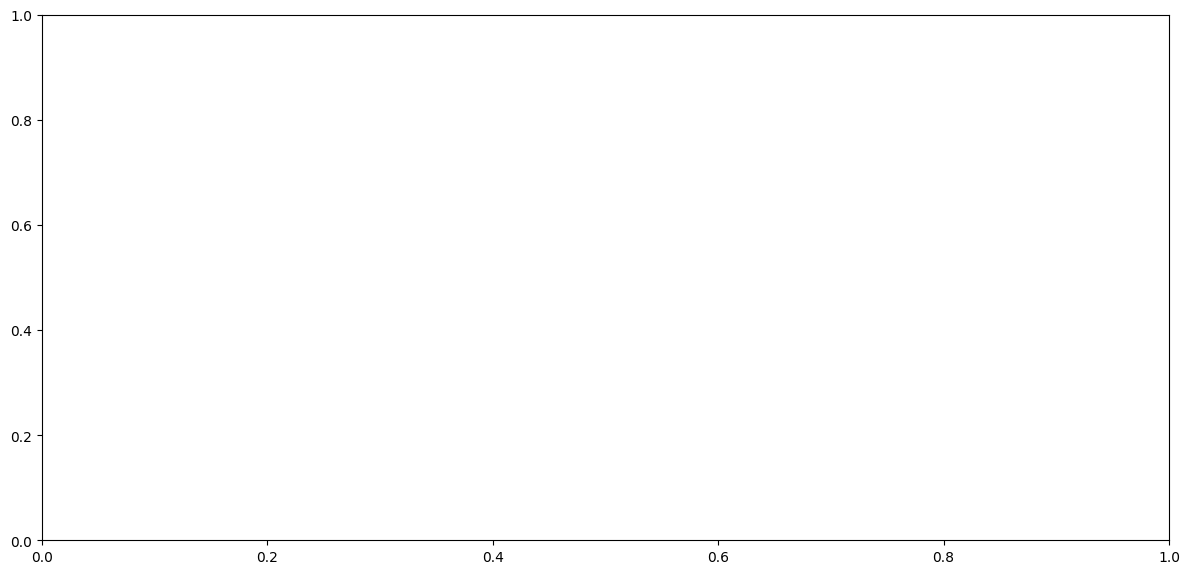

MoviePy - Building file  .\gifs\None_01-08-2023_10-23_1.webm
MoviePy - - Generating GIF frames.


MoviePy - - File ready: .\gifs\None_01-08-2023_10-23_1.webm.


[   action   rewards                                               info
 0       4    0.3000  {'initial_state': {'b75a9424-5c21-4379-abba-62...
 1       2    0.3000  {'initial_state': {'b75a9424-5c21-4379-abba-62...
 2       4    0.3000  {'initial_state': {'b75a9424-5c21-4379-abba-62...
 3       4    0.3000  {'initial_state': {'b75a9424-5c21-4379-abba-62...
 4       5    0.4231  {'initial_state': {'b75a9424-5c21-4379-abba-62...
 5       3    0.4231  {'initial_state': {'b75a9424-5c21-4379-abba-62...
 6       5    0.4231  {'initial_state': {'b75a9424-5c21-4379-abba-62...
 7       3    0.4231  {'initial_state': {'b75a9424-5c21-4379-abba-62...
 8       2    0.3000  {'initial_state': {'b75a9424-5c21-4379-abba-62...
 9       2    0.2000  {'initial_state': {'b75a9424-5c21-4379-abba-62...
 10      3    0.4231  {'initial_state': {'b75a9424-5c21-4379-abba-62...
 11      4    0.2600  {'initial_state': {'b75a9424-5c21-4379-abba-62...
 12      0    0.3000  {'initial_state': {'b75a9424-5c21-4379-abb

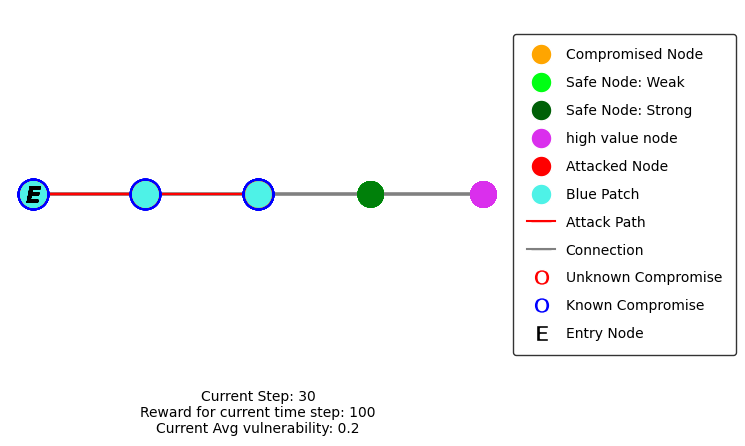

In [10]:
# Create gif
loop = ActionLoop(eval_env, s_agent, episode_count=1)
loop.gif_action_loop(save_gif=True, render_network=True, gif_output_directory='.\gifs', webm_output_directory='.\gifs')

In [11]:
loop = ActionLoop(eval_env, s_agent, episode_count=1)
print(loop)

## Replay

In [12]:
import pandas as pd

In [13]:
        complete_results = []
        for i in range(100):
            results = pd.DataFrame(
                columns=["action", "rewards", "info", "new_state"]
            )  
            obs = eval_env.reset()
            done = False

            while not done:
                # gets the agents prediction for the best next action to take
                action, _states = s_agent.predict(obs, deterministic= True)

                # step the env
                obs, rewards, done, info = eval_env.step(action)

                results.loc[len(results.index)] = [action, rewards, info, obs]

            complete_results.append(results)

In [14]:
complete_results[1]

,action,rewards,info,new_state
0,4,0.3000,{'initial_state': {'b75a9424-5c21-4379-abba-62...,"[0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, ..."
1,4,0.3000,{'initial_state': {'b75a9424-5c21-4379-abba-62...,"[0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, ..."
2,2,0.3000,{'initial_state': {'b75a9424-5c21-4379-abba-62...,"[0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, ..."
3,4,0.3000,{'initial_state': {'b75a9424-5c21-4379-abba-62...,"[0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, ..."
4,5,0.5000,{'initial_state': {'b75a9424-5c21-4379-abba-62...,"[0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, ..."
5,2,0.3000,{'initial_state': {'b75a9424-5c21-4379-abba-62...,"[0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, ..."
6,2,0.3000,{'initial_state': {'b75a9424-5c21-4379-abba-62...,"[0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, ..."
7,5,0.4231,{'initial_state': {'b75a9424-5c21-4379-abba-62...,"[0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, ..."
8,3,0.4231,{'initial_state': {'b75a9424-5c21-4379-abba-62...,"[0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, ..."
9,5,0.4231,{'initial_state': {'b75a9424-5c21-4379-abba-62...,"[0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, ..."


In [15]:
complete_results[1]['info'][11]

{'initial_state': {'b75a9424-5c21-4379-abba-6296ad6e49b6': 0,
  '3afd6bca-8b71-451f-ac05-23c62869f31d': 0,
  'f2882641-56a0-43c2-b28d-b0deed647b19': 0,
  '113e6418-c7d4-4f9d-830c-352cb2216bc2': 0,
  'f08e2045-55b8-4c23-8d11-fd85d107f15f': 0},
 'initial_blue_view': {'b75a9424-5c21-4379-abba-6296ad6e49b6': 0,
  '3afd6bca-8b71-451f-ac05-23c62869f31d': 0,
  'f2882641-56a0-43c2-b28d-b0deed647b19': 0,
  '113e6418-c7d4-4f9d-830c-352cb2216bc2': 0,
  'f08e2045-55b8-4c23-8d11-fd85d107f15f': 0},
 'initial_vulnerabilities': {'b75a9424-5c21-4379-abba-6296ad6e49b6': 0.4000000000000001,
  '3afd6bca-8b71-451f-ac05-23c62869f31d': 0.6000000000000001,
  'f2882641-56a0-43c2-b28d-b0deed647b19': 0.8,
  '113e6418-c7d4-4f9d-830c-352cb2216bc2': 0.8,
  'f08e2045-55b8-4c23-8d11-fd85d107f15f': 0.8},
 'initial_red_location': None,
 'initial_graph': {Node(uuid='b75a9424-5c21-4379-abba-6296ad6e49b6', name='PC 1', high_value_node=False, entry_node=True, vulnerability=0.8, x_pos=-1.0, y_pos=0.01): {Node(uuid='3afd6bca

In [23]:
complete_results[1]['new_state'][11]


array([0. , 1. , 0. , 0. , 0. , 1. , 0. , 1. , 0. , 0. , 0. , 1. , 0. ,
       1. , 0. , 0. , 0. , 1. , 0. , 1. , 0. , 0. , 0. , 1. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0.2, 0.2, 0.8, 0.8,
       0.8, 1. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 1. , 0.7],
      dtype=float32)